<h1 style="color:red; align:center"><center>MODELLING THE SPATIO-TEMPORAL DYNAMICS OF LOW-LEVEL CLOUDS ACROSS WEST AFRICA USING MACHINE LEARNING ALGORITHMS</center></h1>

# IMPORTING LIBRARIES

In [1]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from warnings import filterwarnings
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import utils
filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from skrebate import ReliefF

Wall time: 6.66 s


# OPENING THE DATASET

In [2]:
%%time
ds = xr.open_dataset('data.nc')
ds

CPU times: user 91 ms, sys: 19.9 ms, total: 111 ms
Wall time: 375 ms


<xarray.Dataset>
Dimensions:    (time: 17532, longitude: 201, latitude: 101, expver: 2)
Coordinates:
  * time       (time) datetime64[ns] 1975-01-01T12:00:00 ... 2022-12-31T12:00:00
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 24.5 24.75 25.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * expver     (expver) float64 1.0 5.0
Data variables:
    d2m        (time, latitude, longitude, expver) float32 ...
    t2m        (time, latitude, longitude, expver) float32 ...
    lcc        (time, latitude, longitude, expver) float32 ...
    slhf       (time, latitude, longitude, expver) float32 ...
    ssr        (time, latitude, longitude, expver) float32 ...
    str        (time, latitude, longitude, expver) float32 ...
    sshf       (time, latitude, longitude, expver) float32 ...
    tp         (time, latitude, longitude, expver) float32 ...
    r          (time, latitude, longitude, expver) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Jan 12 12:00:43 2023: cdo merge new_dataset.nc rh.nc da...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

# PREPROCESSING DATA

CPU times: user 13 s, sys: 3.96 s, total: 17 s
Wall time: 1min 45s


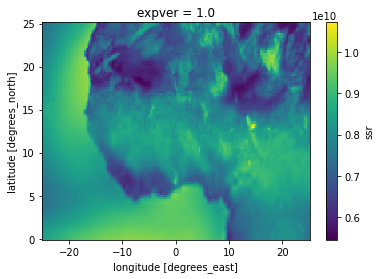

In [3]:
%%time
(ds.ssr.sel(longitude=slice(-25, 25), latitude=slice(25, 0),expver=1.0)*3600).mean('time').plot()

CPU times: user 7.52 s, sys: 1.74 s, total: 9.25 s
Wall time: 9.25 s


Text(0.5, 1.0, '5.0 - 1.0')

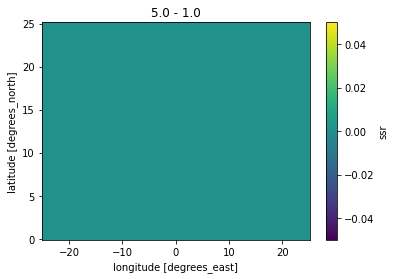

In [4]:
%%time
fig, axes = plt.subplots(ncols=1)
d = ds.ssr.sel(longitude=slice(-25, 25), latitude=slice(25, 0))

'''
d.sel(expver=1.0).mean('time').plot(ax = axes[0])
axes[0].set_title('1.0')

d.sel(expver=5.0).mean('time').plot(ax = axes[1])
axes[0].set_title('5.0')
'''
( d.sel(expver=5.0) - d.sel(expver=1.0)).mean('time').plot(ax = axes)
axes.set_title('5.0 - 1.0')



# SELECTING FEATURES: CHOOSING ATMOSPHERIC VARIABLES THAT ARE MOST RELEVANT TO PREDICTING LOW CLOUD COVER

# POINT DATA EVALUATION

In [5]:
%%time
ds = xr.open_dataset('data.nc')
a = ds.sel(latitude=6.68,longitude=-1.56, method="nearest" )
aa = a.where(a['time.year']>=1975,drop=True).where(a['time.year']<2000, drop=True)
b=aa[['time', 'd2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r','longitude','latitude']]
df = b.to_dataframe()
df.to_csv('point-data.csv')

CPU times: user 10.6 s, sys: 20 s, total: 30.6 s
Wall time: 10min 32s


In [6]:
df = pd.read_csv("point-data.csv",usecols=['time','d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
df

,time,d2m,t2m,slhf,ssr,str,sshf,tp,lcc,r
0,1975-01-01 12:00:00,288.95780,303.44620,-704986.0,2669338.0,-477702.44,-879232.56,0.000000,0.000000,39.066547
1,1975-01-01 12:00:00,288.95780,303.44620,-704986.0,2669338.0,-477702.44,-879232.56,0.000000,0.000000,39.066547
2,1975-01-02 12:00:00,291.40820,302.88943,-689775.3,2654768.2,-447420.12,-939228.50,0.000000,0.088169,48.188683
3,1975-01-02 12:00:00,291.40820,302.88943,-689775.3,2654768.2,-447420.12,-939228.50,0.000000,0.088169,48.188683
4,1975-01-03 12:00:00,292.89010,302.84662,-674564.6,2628029.0,-423092.56,-977965.75,0.000000,0.226680,52.529970
...,...,...,...,...,...,...,...,...,...,...
18257,1999-12-29 12:00:00,292.31564,301.53036,-957679.1,2565005.0,-363884.20,-749729.06,0.000000,0.066287,51.361526
18258,1999-12-30 12:00:00,292.00577,302.60535,-958030.1,2624065.5,-396709.44,-788506.94,0.000000,0.121099,51.988106
18259,1999-12-30 12:00:00,292.00577,302.60535,-958030.1,2624065.5,-396709.44,-788506.94,0.000000,0.121099,51.988106
18260,1999-12-31 12:00:00,294.11298,301.46400,-869924.9,2255690.5,-336038.88,-653841.20,0.000088,0.135199,55.971348


In [7]:
# In the original dataset, the energy values was provided in joules per hour (J/h). 
# However, when working with time series data, it is common to use consistent time units for easier analysis and interpretation.

# By dividing the energy values by 3600 (the number of seconds in an hour), you are converting the energy units from joules 
# per hour to joules per second (J/s). 
# This conversion allows for more meaningful and standardized comparisons, calculations, and interpretations of the energy 
# values over time.
df = pd.read_csv("point-data.csv",usecols=['time','d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
df['ssr'] = df['ssr']/3600
df['str'] = df['str']/3600
df['slhf'] = df['slhf']/3600
df['sshf'] = df['sshf' ]/3600
df.to_csv('point-data.csv')


In [5]:
df = pd.read_csv("point-data.csv",usecols=['d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
def standardized_data(x):
    return (x - x.mean())/x.std()
standardized_data(df).to_csv('std.csv')

In [15]:
# def standardized_data(x):
#     return (x - x.mean())/x.std()
    

In [16]:
# %%time
# standardized_data(df)

In [17]:
# %%time

# stand_df = df.apply(standardized_data)
# stand_df

In [18]:
# stand_df.plot(legend=False)

In [11]:
from scipy.stats import pearsonr
df = pd.read_csv("point-data.csv",usecols=['d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
bias_matrix = pd.DataFrame(columns=df.columns, index=df.columns)

for i, var in enumerate(df.columns):
    for j, var2 in enumerate(df.columns):
        if i <= j:
            bias = np.mean(df[var]) - np.mean(df[var2])
            #bias = np.mean(df[var]- df[var2]) 
            bias_matrix.iloc[i,j] = bias
            #print(f"Bias between {var} and {var2}: {bias}")
        #elif i == j:
        #    bias = 0
        #    bias_matrix.iloc[i,j] = bias
            #print(f"Bias between {var} and {var2}: 0")
        elif i > j:
            bias = np.mean(df[var2]) - np.mean(df[var])
            #bias = np.mean(df[var2]-df[var]) 
            bias_matrix.iloc[i,j] = bias

bias_matrix.to_csv('bias.csv')
bias_matrix

,d2m,t2m,slhf,ssr,str,sshf,tp,lcc,r
d2m,0.0,-7.354548,530.181471,-237.151886,354.601078,438.161207,294.430406,293.925216,230.374716
t2m,-7.354548,0.0,537.53602,-229.797337,361.955627,445.515755,301.784954,301.279764,237.729264
slhf,530.181471,537.53602,0.0,-767.333357,-175.580393,-92.020265,-235.751065,-236.256255,-299.806756
ssr,-237.151886,-229.797337,-767.333357,0.0,591.752964,675.313092,531.582291,531.077102,467.526601
str,354.601078,361.955627,-175.580393,591.752964,0.0,83.560128,-60.170672,-60.675862,-124.226363
sshf,438.161207,445.515755,-92.020265,675.313092,83.560128,0.0,-143.730801,-144.235991,-207.786491
tp,294.430406,301.784954,-235.751065,531.582291,-60.170672,-143.730801,0.0,-0.50519,-64.05569
lcc,293.925216,301.279764,-236.256255,531.077102,-60.675862,-144.235991,-0.50519,0.0,-63.5505
r,230.374716,237.729264,-299.806756,467.526601,-124.226363,-207.786491,-64.05569,-63.5505,0.0


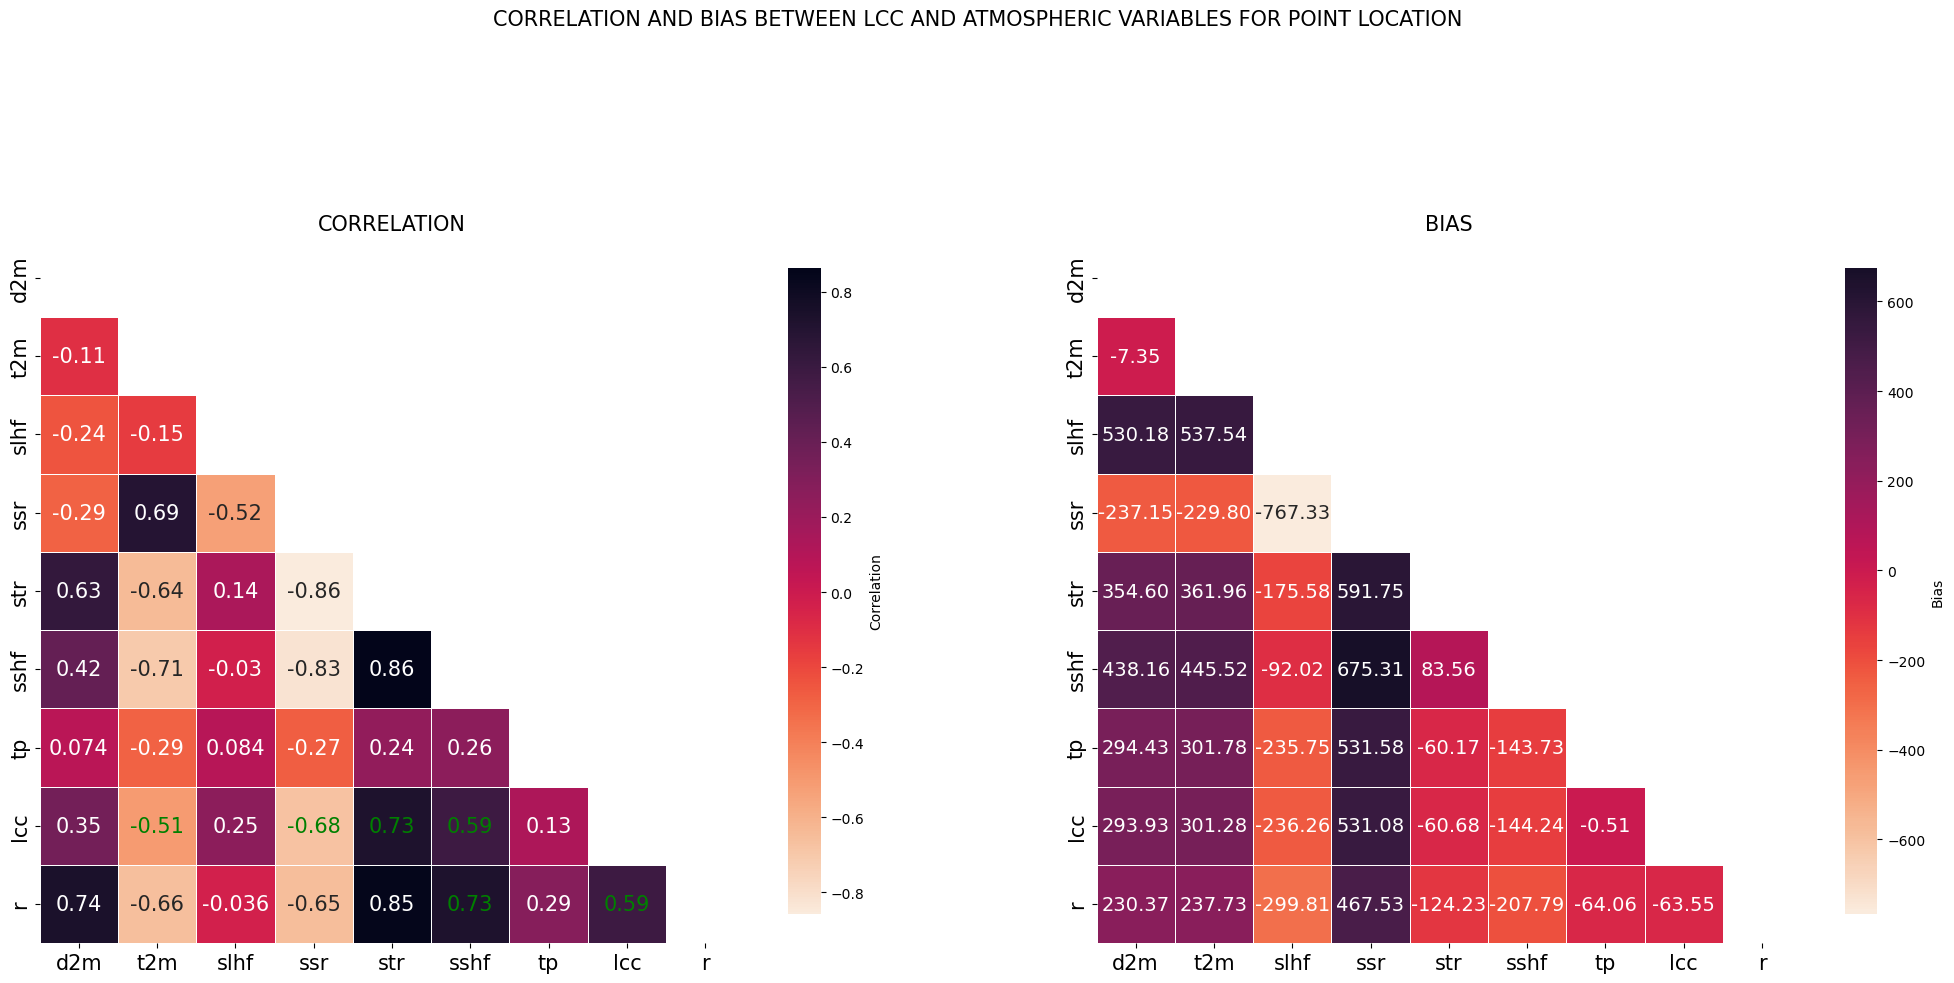

In [14]:
df = pd.read_csv("bias.csv",usecols=['d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
df1 = pd.read_csv("point-data.csv",usecols=['d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
columns = ['d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r']
corr = df1.corr()

threshold =0.5
mask_corrs = np.triu(np.ones_like(corr,dtype=bool))


# cmap_corr = sns.diverging_palette(220,10, as_cmap=True)
cmap_bias = sns.color_palette("rocket_r", as_cmap=True)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(25,12))
sns.heatmap(corr, cmap=cmap_bias, annot=True, annot_kws={'fontsize':15}, center=0, square=True,
             linewidths=.5,
             cbar_kws={"shrink": .7,'label':'Correlation'},mask=mask_corrs,ax=ax1)



mask_bias = np.triu(np.ones_like(df,dtype=bool))
sns.heatmap(df, cmap=cmap_bias, annot=True, annot_kws={'fontsize':14}, center=0, square=True,
             linewidths=.5,
             cbar_kws={"shrink": .7,'label':'Bias'}, fmt='.2f',mask=mask_bias, yticklabels=df.columns,ax=ax2)


corr_colors = {'0.73':'green','-0.68':'green','-0.51':'green','0.59':'green'}

#corr_colors = {str(val): sns.color_palette("RdBu_r",11)[idx] for idx, val in enumerate(np.arange(-0.51,1,0.2))}
for text in ax1.texts:
    if text.get_text() in corr_colors:
        text.set_color(corr_colors[text.get_text()])
        

#plt.show()
ax1.set_title('CORRELATION',fontsize='15')
ax1.tick_params(axis='both',labelsize=15)
ax2.set_title('BIAS',fontsize='15')
ax2.tick_params(axis='both',labelsize=15)
#plt.tight_layout()
fig.suptitle('CORRELATION AND BIAS BETWEEN LCC AND ATMOSPHERIC VARIABLES FOR POINT LOCATION',fontsize='15')
plt.show()

# USING FEATURE SELECTION ALGORITHMS

# ANOVA-F TEST

In [3]:
df = pd.read_csv('point-data.csv', usecols=['d2m','t2m','slhf','ssr','str','sshf','tp','lcc','r'])


X = df.drop(['lcc',],axis=1)
y = df['lcc']
X =np.abs(X)

y = y.values.ravel()
k = 1
selector = SelectKBest(f_classif, k=k)
selector.fit(X,y)

scores = selector.scores_
p_values = selector.pvalues_
selector_indices = selector.get_support(indices=True)
selector_features = X.columns[selector_indices]
selector_features

Index(['str'], dtype='object')

# RELIEfF FEATURE SELECTION

In [4]:
%%time
df = pd.read_csv('point-data.csv', usecols=['d2m','t2m','slhf','ssr','str','sshf','tp','lcc','r'])


X = df.drop(['lcc',],axis=1)
y = df['lcc']
#X =np.abs(X)

k = 8
relieff = ReliefF(n_features_to_select=k,n_neighbors=10)

relieff.fit(X.values, y.values)
weight = relieff.feature_importances_
selected_indices = weight.argsort()[::-1][:k]
selected_features = X.columns[selected_indices]


Wall time: 8min 21s


In [5]:
selected_features

Index(['str', 'r', 'd2m', 'slhf', 't2m', 'sshf', 'ssr', 'tp'], dtype='object')

In [2]:
%%time
class ML: 
    from sklearn.model_selection import train_test_split, TimeSeriesSplit
    from sklearn import tree

    def __init__(self, data, var):
        self.data = data
        self.var = var
        
        
    def xar_imp(data, var):
        try:
            import xarray as xr
        except:
            !pip install xarray
            import xarray as xr

        df = xr.open_dataset(data)[var]
        return df
    
    def df_timegrp(df, data):
        a,b,c = np.meshgrid(data.time.groupby('time.year').mean('time'),data.longitude,data.latitude)
        df['longitude'], df['latitude'] = b.flatten(), c.flatten()
        df = df.set_index(a.flatten())
        return df
    
    def model(train_in, train_out, test_size=0.5, method='DT'):
        X_train, X_test, Y_train, Y_test  = train_test_split(train_in, train_out, test_size=test_size)
        
        ### Model Method Selection
        if method == 'DT':     #Decision Tree
            from sklearn.tree import DecisionTreeClassifier
            model = DecisionTreeClassifier()
        elif method == 'LR':   #Linear Regression
            from sklearn.linear_model import LinearRegression
            model = LinearRegression()
        elif method == 'RF':   #Random Forest
            from sklearn.ensemble import RandomForestClassifier
            model=RandomForestClassifier(max_depth=2)
        elif method == 'LogR':   #Logistic Regression
            from sklearn.linear_model import LogisticRegression
            model = LogisticRegression()
        elif method == 'KNN':  #K Nearest Neighbors
            from sklearn.neighbors import KNeighborsClassifier
            model = KNeighborsClassifier(n_neighbors=8)
        elif method == 'NB':  #Naive Bayes
            from sklearn.naive_bayes import GaussianNB
            model = GaussianNB()
        elif method == 'SVM':  #Support Vector Machine
            from sklearn.svm import SVC
            model = SVC()
        elif method == 'RNC':  #Radius Neighbors Classifier
            from sklearn.neighbors import  RadiusNeighborsClassifier
            model=RadiusNeighborsClassifier(radius=18.0)
        elif method == 'PAC':  #Passive Aggressive Classifier
            from sklearn.linear_model import PassiveAggressiveClassifier
            model = PassiveAggressiveClassifier()
        elif method == 'BNB':  #BernoulliNB
            from sklearn.naive_bayes import BernoulliNB
            model = BernoulliNB()
        elif method == 'ETC':  #ExtraTreeClassifier
            from sklearn.tree import ExtraTreeClassifier
            model = ExtraTreeClassifier()
        elif method == 'BC':  #Bagging Classifier
            from sklearn.ensemble import BaggingClassifier
            model=BaggingClassifier()
        elif method == 'ABC':  #AdaBoost Classifier
            from sklearn.ensemble import AdaBoostClassifier
            model=AdaBoostClassifier()
        elif method == 'GBC':  #GradientBoosting Classifier
            from sklearn.ensemble import GradientBoostingClassifier
            model=GradientBoostingClassifier()
        elif method == 'LDA':  #Linear Discriminant Analysis
            from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
            model=LinearDiscriminantAnalysis()
        elif method == 'QDA':  #Quadratic Discriminant Analysis
            from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
            model=QuadraticDiscriminantAnalysis()
        else:  #Default is Decision Tree
            from sklearn.tree import DecisionTreeClassifier
            model = DecisionTreeClassifier()
            
        model.fit(X_train, Y_train)
        #tree.export_graphviz(model, )
        predictions = model.predict(X_test)
        return X_train, X_test, Y_train, Y_test, predictions, model
    
    def trendline(x,y, deg=1, ax=None, c=None):
        z = np.polyfit(x, y, deg) # Polynomial fit
        p = np.poly1d(z)
        if ax:
            ax.plot(x,p(x),color=c,linestyle="--")

Wall time: 0 ns


# USING SELECTED VARIABLES 

# THE MODEL RESULT

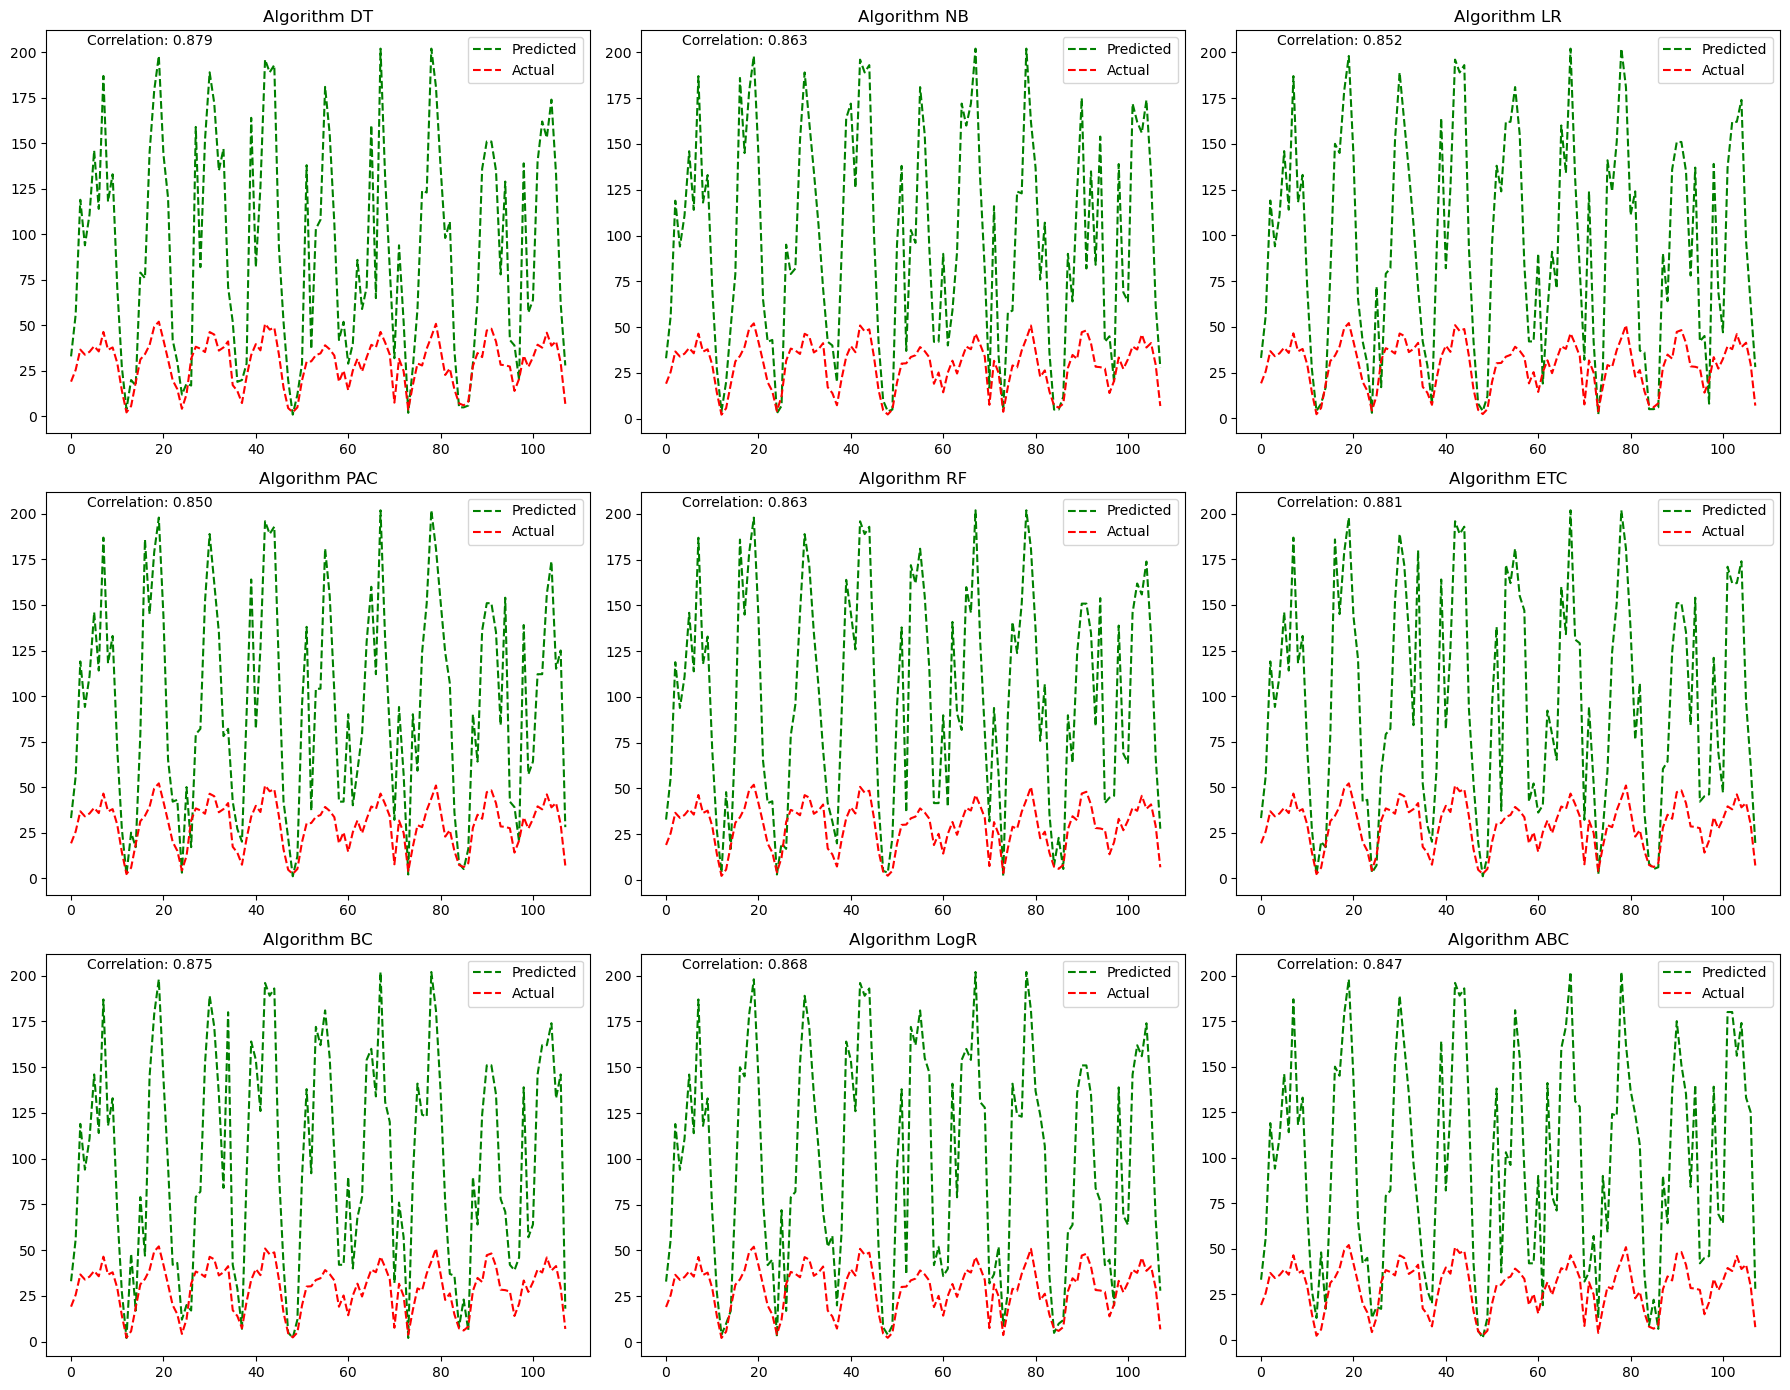

Wall time: 2min 33s


In [3]:
%%time
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
inp = pd.read_csv(r'point-data.csv', usecols=['time', 'd2m', 't2m', 'slhf', 'ssr', 'str', 'sshf', 'tp', 'lcc', 'r'])
methods = ['DT', 'NB', 'LR', 'PAC', 'RF', 'ETC','BC','LogR','ABC']  # List of methods
np.random.seed(42)  # Set a specific random seed for reproducibility

for i, method in enumerate(methods):
    if i < 7:
        ax = axes[i // 3, i % 3]
    else:
        ax = axes[2, 2]  # Additional plot in the last position
    T_in = inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = inp['lcc']
    lab = preprocessing.LabelEncoder()
    T_out = pd.DataFrame(lab.fit_transform(T_out))
    model = ML.model(T_in, T_out, method=[method])[5]  # Get the model for the current method
    
    ann_inp = inp.set_index('time').copy()
    ann_inp.index = pd.to_datetime(ann_inp.index)
    ann_inp = ann_inp.groupby(pd.Grouper(freq='M')).sum()

    T_in = ann_inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = ann_inp[['lcc']]
    
    x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
    y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)

    lab = preprocessing.LabelEncoder()
    y_train = pd.DataFrame(lab.fit_transform(y_train))
    model.fit(x_train, y_train)
   
    
    # Plot predicted and actual values
    axes[i // 3, i % 3].plot(model.predict(x_test), color='g', linestyle='--', label='Predicted')
    axes[i // 3, i % 3].plot(y_test, color='r', linestyle='--', label='Actual')
    axes[i // 3, i % 3].set_title(f'Algorithm {method}')
    axes[i // 3, i % 3].legend()

    # Calculate correlation and add it to the plot
    correlation = np.corrcoef(y_test.T.values[0], model.predict(x_test))[0, 1]
    axes[i // 3, i % 3].text(0.19, 0.99, f'Correlation: {correlation:.3f}', transform=axes[i // 3, i % 3].transAxes,
                             ha='center', va='top')

plt.tight_layout()
plt.show()



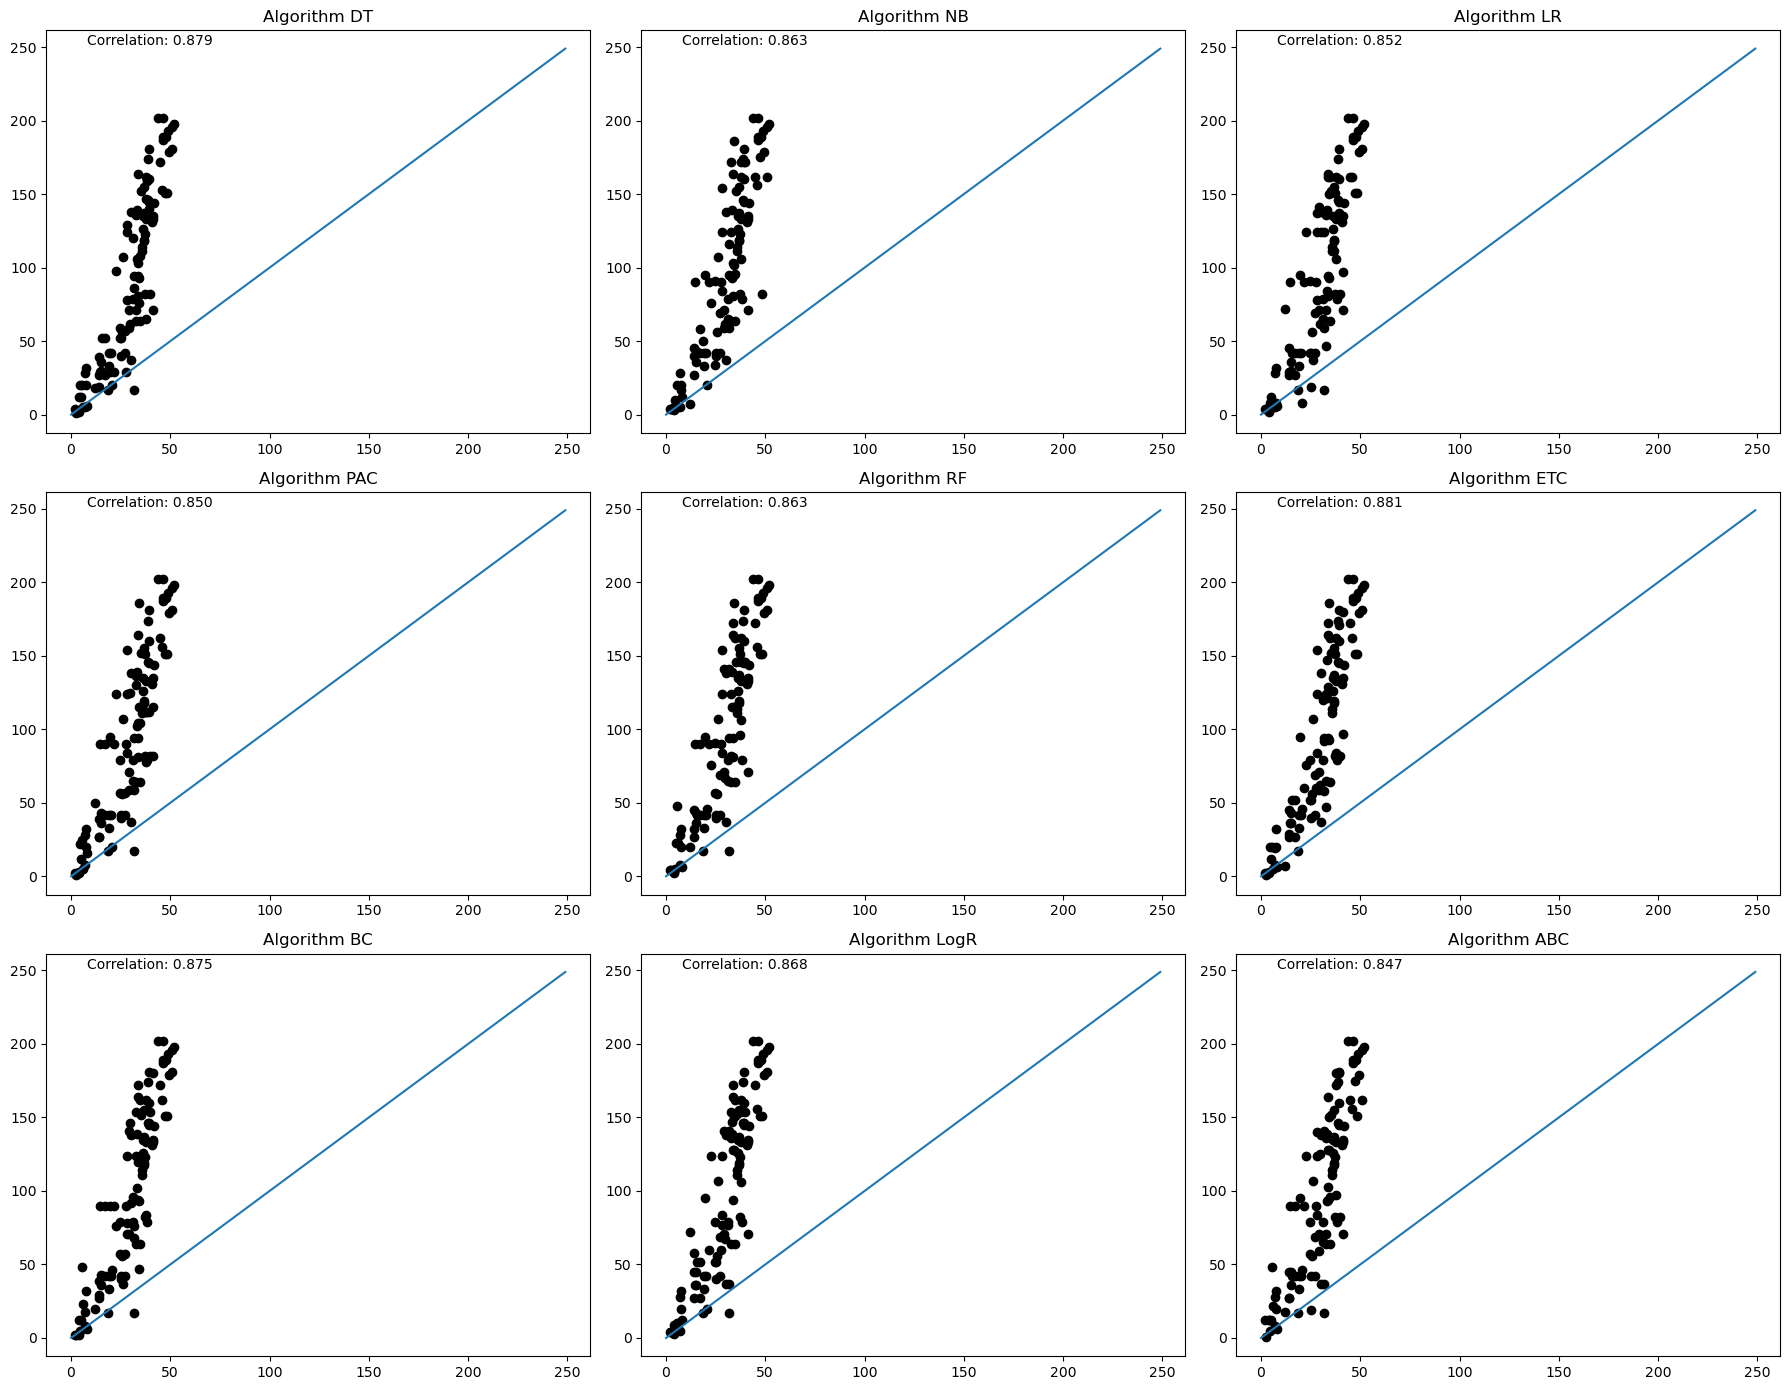

Wall time: 2min 27s


In [93]:
%%time
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
inp = pd.read_csv(r'point-data.csv', usecols=['time', 'd2m', 't2m', 'slhf', 'ssr', 'str', 'sshf', 'tp', 'lcc', 'r'])
methods = ['DT', 'NB', 'LR', 'PAC', 'RF', 'ETC','BC','LogR','ABC']  # List of methods
np.random.seed(42)  # Set a specific random seed for reproducibility

for i, method in enumerate(methods):
    if i < 7:
        ax = axes[i // 3, i % 3]
    else:
        ax = axes[2, 2]  # Additional plot in the last position
    T_in = inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = inp['lcc']
    lab = preprocessing.LabelEncoder()
    T_out = pd.DataFrame(lab.fit_transform(T_out))
    model = ML.model(T_in, T_out, method=[method])[5]  # Get the model for the current method
    
    ann_inp = inp.set_index('time').copy()
    ann_inp.index = pd.to_datetime(ann_inp.index)
    ann_inp = ann_inp.groupby(pd.Grouper(freq='M')).sum()

    T_in = ann_inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = ann_inp[['lcc']]
    
    x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
    y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)

    lab = preprocessing.LabelEncoder()
    y_train = pd.DataFrame(lab.fit_transform(y_train))
    model.fit(x_train, y_train)

    # Plot predicted and actual values
    axes[i // 3, i % 3].plot(y_test, model.predict(x_test), 'ko')
    axes[i // 3, i % 3].plot(range(250))
    axes[i // 3, i % 3].set_title(f'Algorithm {method}')
    #axes[i // 3, i % 3].legend()

    # Calculate correlation and add it to the plot
    correlation = np.corrcoef(y_test.T.values[0], model.predict(x_test))[0, 1]
    axes[i // 3, i % 3].text(0.19, 0.99, f'Correlation: {correlation:.3f}', transform=axes[i // 3, i % 3].transAxes,
                             ha='center', va='top')

plt.tight_layout()
plt.show()


# WITH BIAS CORRECTION APPLIED TO THE MODEL RESULTS

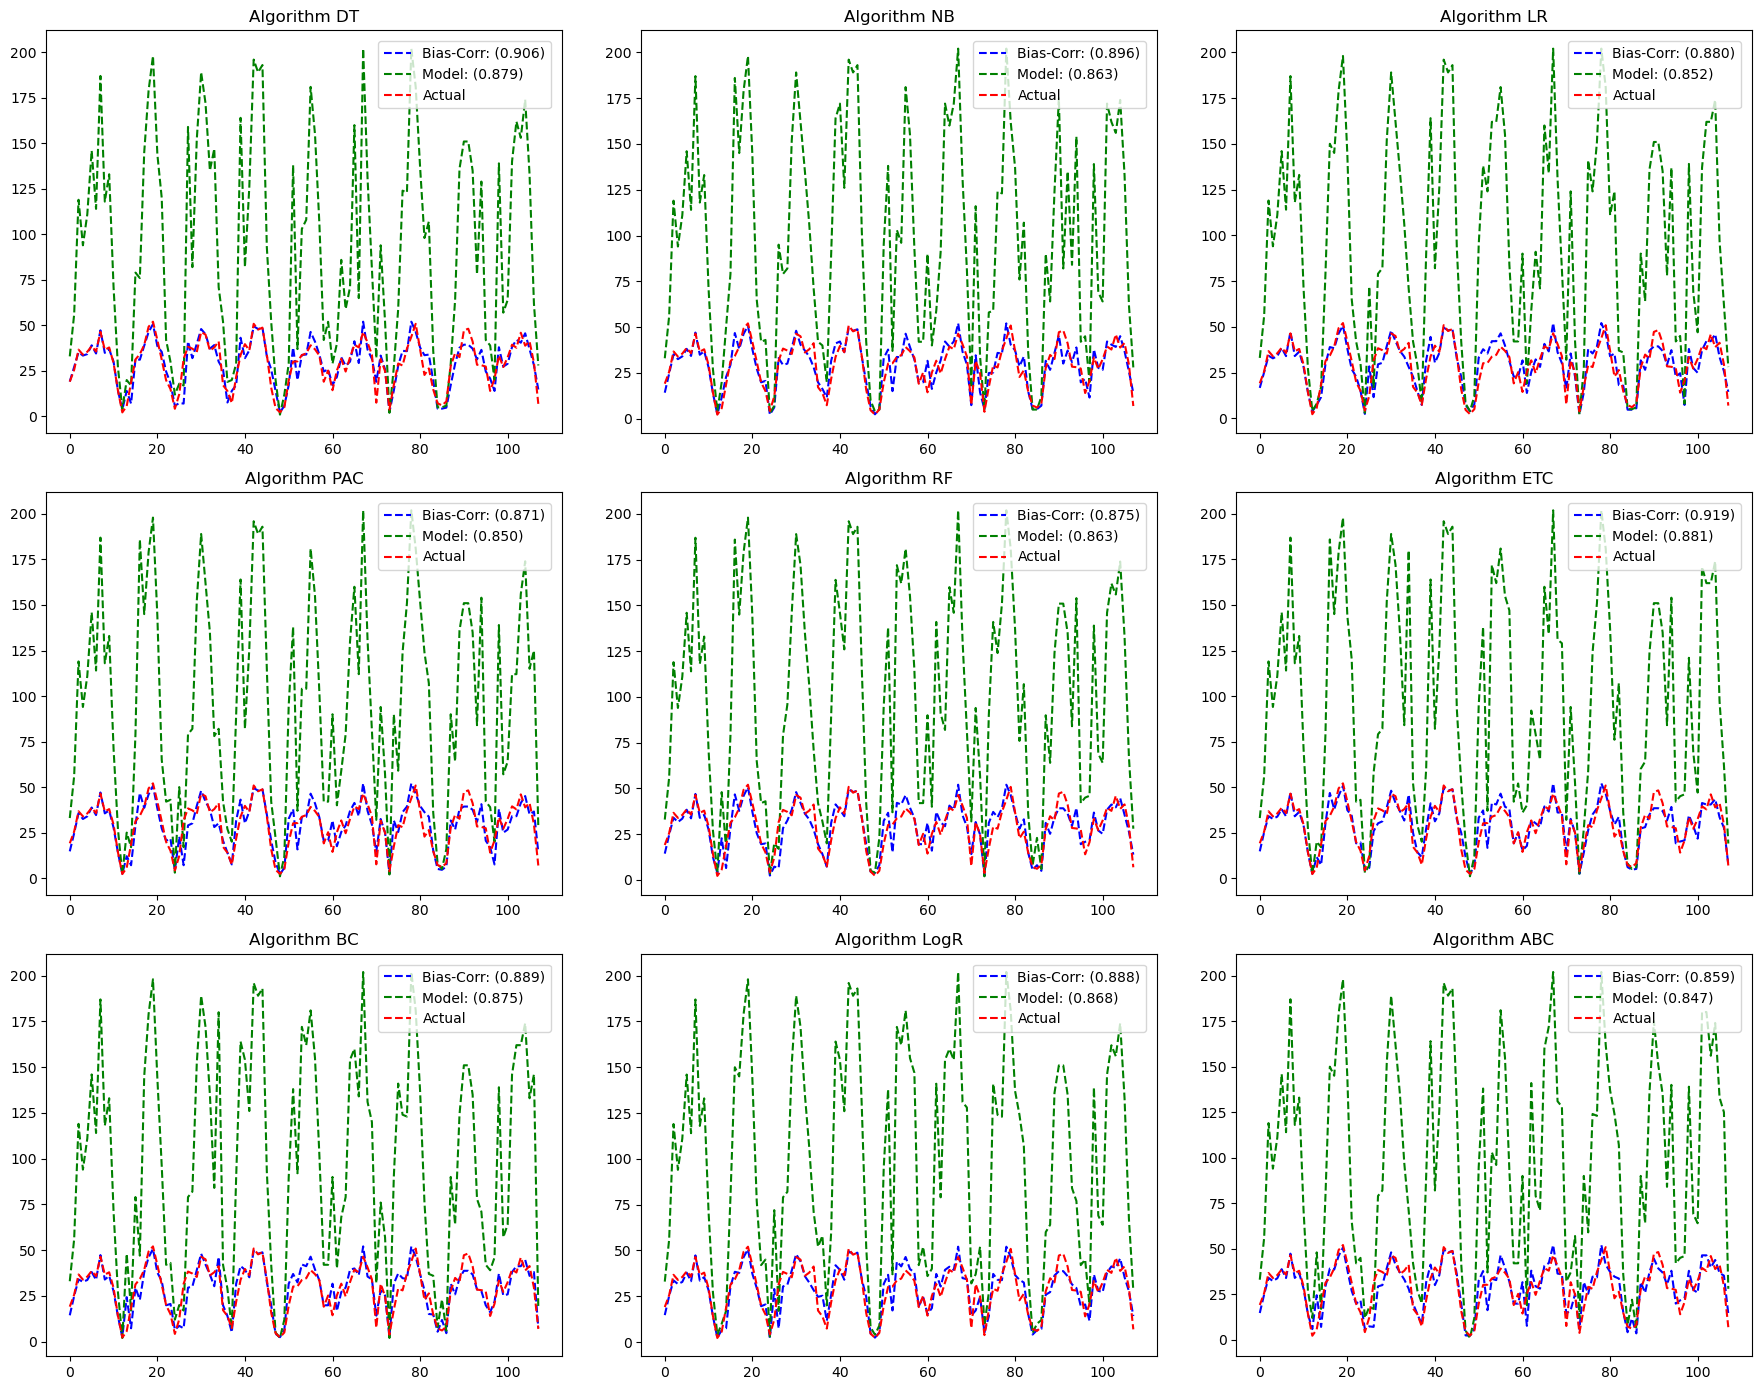

Wall time: 2min 45s


In [10]:
%%time
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
inp = pd.read_csv(r'point-data.csv', usecols=['time', 'd2m', 't2m', 'slhf', 'ssr', 'str', 'sshf', 'tp', 'lcc', 'r'])
methods = ['DT', 'NB', 'LR', 'PAC', 'RF', 'ETC', 'BC', 'LogR', 'ABC']  # List of methods
np.random.seed(42)  # Set a specific random seed for reproducibility

for i, method in enumerate(methods):
    if i < 7:
        ax = axes[i // 3, i % 3]
    else:
        ax = axes[2, 2]  # Additional plot in the last position
    T_in = inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = inp['lcc']
    lab = preprocessing.LabelEncoder()
    T_out = pd.DataFrame(lab.fit_transform(T_out))
    model = ML.model(T_in, T_out, method=[method])[5]  # Get the model for the current method

    ann_inp = inp.set_index('time').copy()
    ann_inp.index = pd.to_datetime(ann_inp.index)
    ann_inp = ann_inp.groupby(pd.Grouper(freq='M')).sum()

    T_in = ann_inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = ann_inp[['lcc']]

    x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
    y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)

    lab = preprocessing.LabelEncoder()
    y_train = pd.DataFrame(lab.fit_transform(y_train))
    y_test = y_test.squeeze()
    model.fit(x_train, y_train)
    model_data = model.predict(x_test)
    
    def bias_correction(y_test, model_data, method='QM'):
        if method == 'QM':
            # Quantile Mapping
            # Calculate the mapping between observed and model data quantiles
            observed_quantiles = np.nanpercentile(y_test, q=np.arange(0, 101))
            model_quantiles = np.nanpercentile(model_data, q=np.arange(0, 101))

            # Map the model data to observed data quantiles
            corrected_data = np.interp(model_data, model_quantiles, observed_quantiles)

        elif method == 'SC':
            # Calculate the mean and standard deviation of observed and model data
            observed_mean = np.nanmean(y_test)
            model_mean = np.nanmean(model_data)
            observed_std = np.nanstd(y_test)
            model_std = np.nanstd(model_data)

            # Scale the model data by matching the mean and standard deviation of observed data
            corrected_data = ((model_data - model_mean) * (observed_std / model_std)) + observed_mean

        return corrected_data

    cor_data = bias_correction(y_test, model_data, method='QM')
    SM_cor_data = bias_correction(y_test, model_data, method='SC')
    correlation_Bias = np.corrcoef(y_test, cor_data)[0, 1]
    correlation_Model = np.corrcoef(y_test, model.predict(x_test))[0,1]
    # Plot predicted and actual values
    axes[i // 3, i % 3].plot(cor_data, color='b', linestyle='--', label=f'Bias-Corr: ({correlation_Bias:.3f})')
    axes[i // 3, i % 3].plot(model.predict(x_test), color='g', linestyle='--', label=f'Model: ({correlation_Model:.3f})')
    axes[i // 3, i % 3].plot(y_test, color='r', linestyle='--', label='Actual')
    axes[i // 3, i % 3].set_title(f'Algorithm {method}')
    axes[i // 3, i % 3].legend(loc =2, bbox_to_anchor=(0.63, 0.99), fontsize = 10)

    # Calculate correlation and add it to the plot
    #correlation = np.corrcoef(y_test, cor_data)[0, 1]
    #axes[i // 3, i % 3].text(0.19, 0.99, f'Correlation: {correlation:.3f}', transform=axes[i // 3, i % 3].transAxes,
    #                         ha='center', va='top')

plt.tight_layout()
plt.show()


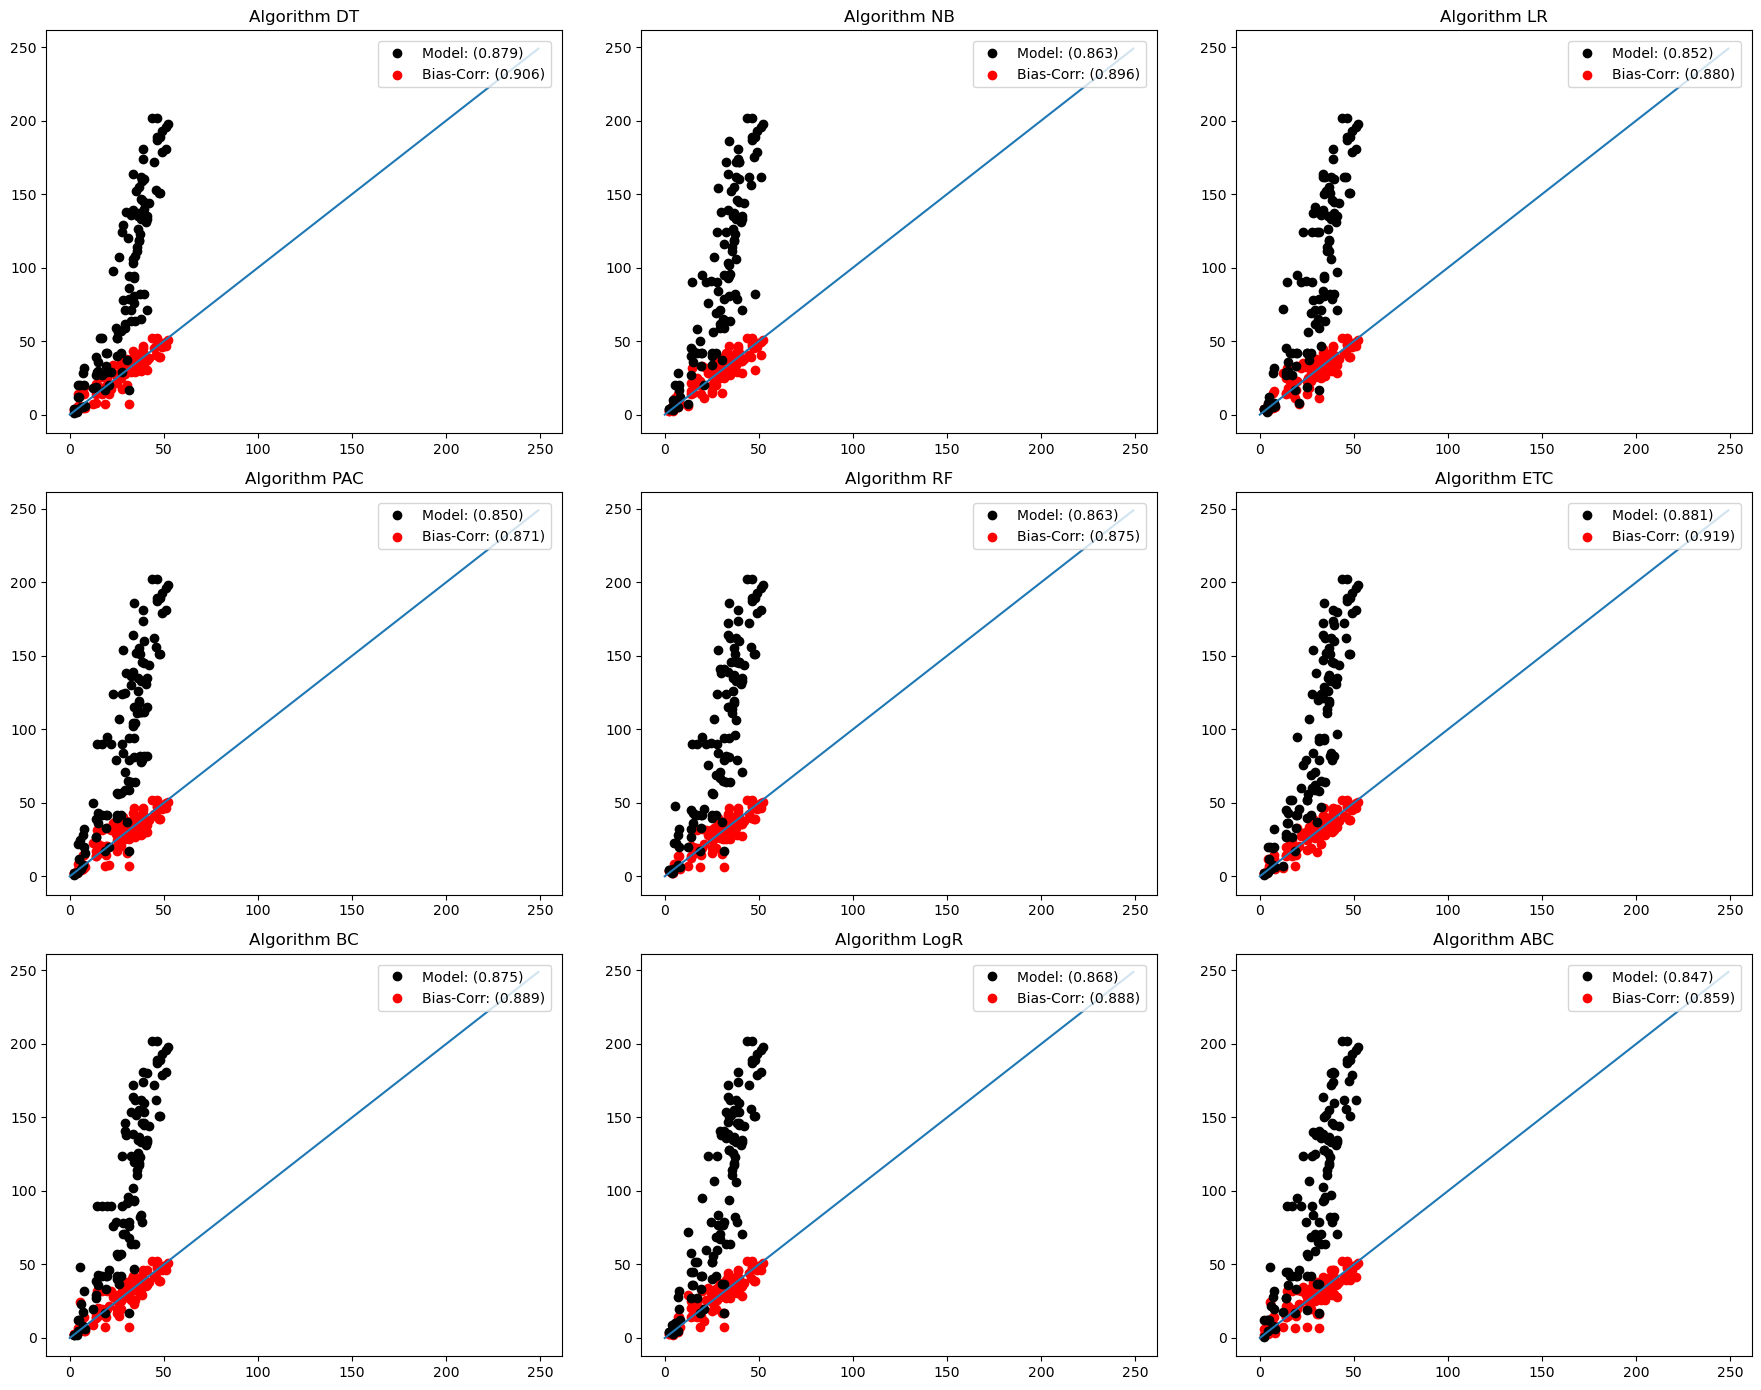

Wall time: 2min 41s


In [4]:
%%time
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
inp = pd.read_csv(r'point-data.csv', usecols=['time', 'd2m', 't2m', 'slhf', 'ssr', 'str', 'sshf', 'tp', 'lcc', 'r'])
methods = ['DT', 'NB', 'LR', 'PAC', 'RF', 'ETC', 'BC', 'LogR', 'ABC']  # List of methods
np.random.seed(42)  # Set a specific random seed for reproducibility

for i, method in enumerate(methods):
    if i < 7:
        ax = axes[i // 3, i % 3]
    else:
        ax = axes[2, 2]  # Additional plot in the last position
    T_in = inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = inp['lcc']
    lab = preprocessing.LabelEncoder()
    T_out = pd.DataFrame(lab.fit_transform(T_out))
    model = ML.model(T_in, T_out, method=[method])[5]  # Get the model for the current method

    ann_inp = inp.set_index('time').copy()
    ann_inp.index = pd.to_datetime(ann_inp.index)
    ann_inp = ann_inp.groupby(pd.Grouper(freq='M')).sum()

    T_in = ann_inp[['ssr', 't2m', 'str', 'sshf', 'r']]
    T_out = ann_inp[['lcc']]

    x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
    x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
    y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)

    lab = preprocessing.LabelEncoder()
    y_train = pd.DataFrame(lab.fit_transform(y_train))
    y_test = y_test.squeeze()
    model.fit(x_train, y_train)
    model_data = model.predict(x_test)
    
    def bias_correction(y_test, model_data, method='QM'):
        if method == 'QM':
            # Quantile Mapping
            # Calculate the mapping between observed and model data quantiles
            observed_quantiles = np.nanpercentile(y_test, q=np.arange(0, 101))
            model_quantiles = np.nanpercentile(model_data, q=np.arange(0, 101))

            # Map the model data to observed data quantiles
            corrected_data = np.interp(model_data, model_quantiles, observed_quantiles)
  
        elif method == 'SC':
            # Calculate the mean and standard deviation of observed and model data
            observed_mean = np.nanmean(y_test)
            model_mean = np.nanmean(model_data)
            observed_std = np.nanstd(y_test)
            model_std = np.nanstd(model_data)

            # Scale the model data by matching the mean and standard deviation of observed data
            corrected_data = ((model_data - model_mean) * (observed_std / model_std)) + observed_mean

        return corrected_data
        return bias_correction_factor
    def estimate_bias_correction_factor(y_test, model_data, method='QM'):
        if method == 'QM':
            # Calculate the mapping between observed and model data quantiles
            observed_quantiles = np.nanpercentile(y_test, q=np.arange(0, 101))
            model_quantiles = np.nanpercentile(model_data, q=np.arange(0, 101))

            # Estimate the bias correction factor as the ratio of observed to model quantiles
            bias_correction_factor = observed_quantiles / model_quantiles

        return bias_correction_factor



     

    cor_data = bias_correction(y_test, model_data, method='QM')
    SM_cor_data = bias_correction(y_test, model_data, method='SC')
    correlation_Bias = np.corrcoef(y_test, cor_data)[0, 1]
    correlation_Model = np.corrcoef(y_test, model.predict(x_test))[0,1]
    # Plot predicted and actual values
    axes[i // 3, i % 3].plot(y_test, model.predict(x_test), 'ko',label=f'Model: ({correlation_Model:.3f})')
    axes[i // 3, i % 3].scatter(y_test, cor_data, color='r',label=f'Bias-Corr: ({correlation_Bias:.3f})')
    axes[i // 3, i % 3].plot(range(250))
    axes[i // 3, i % 3].set_title(f'Algorithm {method}')
    axes[i // 3, i % 3].legend(loc =2, bbox_to_anchor=(0.63, 0.99), fontsize = 10)

    # Calculate correlation and add it to the plot
    #correlation = np.corrcoef(y_test, cor_data)[0, 1]
    #axes[i // 3, i % 3].text(0.19, 0.99, f'Correlation: {correlation:.3f}', transform=axes[i // 3, i % 3].transAxes,
    #                         ha='center', va='top')

plt.tight_layout()
plt.show()


In [11]:
bias_factor = estimate_bias_correction_factor(y_test, model_data, method='QM')
bias_factor.mean()

0.3692481303443958

In [20]:
# %%time

# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import preprocessing
# inp = pd.read_csv(r'point-data.csv',usecols=['time','d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
# #inp['dd'] = inp.t2m - inp.d2m
# T_in = inp[['ssr','t2m','str','sshf','r']]

# T_out = inp['lcc']
# lab = preprocessing.LabelEncoder()
# #y_transformed = lab.fit_transform(T_out)
# T_out = pd.DataFrame(lab.fit_transform(T_out))

# # T_out = y_transformed


# ts = 0.25  #test_size in fraction
# accuracies = dict()

# # 'LogR', 'GBC'
# # 'RNC', 'QDA','PAC','BNB','ETC','BC','ABC','LDA'
# #method = ['DT']



# [a, b, c, d, e, model_DT] = ML.model(T_in, T_out, method=['DT'])
# [a, b, c, d, e, model_NB] = ML.model(T_in, T_out, method=['NB'])
# [a, b, c, d, e, model_LR] = ML.model(T_in, T_out, method=['LR'])
# [a, b, c, d, e, model_PAC] = ML.model(T_in, T_out, method=['PAC'])



# ann_inp = inp.set_index('time').copy()
# ann_inp.index = pd.to_datetime(ann_inp.index)
# ann_inp = ann_inp.groupby(pd.Grouper(freq='M')).sum()

# T_in =ann_inp[['ssr', 't2m','str','sshf','r']]
# #T_in =ann_inp[['ssr']]
# T_out = ann_inp[['lcc']]


    

    
    
# x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
# y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
# x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
# y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)


# lab = preprocessing.LabelEncoder()
# #y_transformed = lab.fit_transform(T_out)
# y_train = pd.DataFrame(lab.fit_transform(y_train))


# model_DT.fit(x_train, y_train)
# model_NB.fit(x_train, y_train)
# model_LR.fit(x_train, y_train)
# model_PAC.fit(x_train, y_train)

# #model_data_DT = model_DT.predict(x_test)
# def bias_correction(y_test, model_data, method='QM'):
#     if method == 'QM':
#         # Quantile Mapping
#         # Calculate the mapping between observed and model data quantiles
#         observed_quantiles = np.nanpercentile(y_test, q=np.arange(0, 101))
#         model_quantiles = np.nanpercentile(model_data, q=np.arange(0, 101))

#         # Map the model data to observed data quantiles
#         corrected_data = np.interp(model_data, model_quantiles, observed_quantiles)
        
#     elif method == 'SC':
#         # Calculate the mean and standard deviation of observed and model data
#         observed_mean = np.nanmean(y_test)
#         model_mean = np.nanmean(model_data)
#         observed_std = np.nanstd(y_test)
#         model_std = np.nanstd(model_data)

#         # Scale the model data by matching the mean and standard deviation of observed data
#         corrected_data = ((model_data - model_mean) * (observed_std / model_std)) + observed_mean

#     return corrected_data


# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Method DT
# cor_data_DT = bias_correction(y_test, model_DT.predict(x_test), method='QM')
# axes[0, 0].plot(cor_data_DT, color='b', linestyle='--', label='Bias-Corr')
# axes[0, 0].plot(model_DT.predict(x_test), color='g', linestyle='--', label='Model')
# axes[0, 0].plot(y_test, color='r', linestyle='--', label='Actual')
# axes[0, 0].set_title('Algorithm DT')
# axes[0, 0].legend()

# correlation_DT = np.corrcoef(y_test.T.values[0], cor_data_DT)[0, 1]
# axes[0, 0].text(0.19, 0.99, f'Correlation: {correlation_DT:.3f}', transform=axes[0, 0].transAxes, ha='center', va='top')

# # Method NB
# cor_data_NB = bias_correction(y_test, model_NB.predict(x_test), method='QM')
# axes[0, 1].plot(cor_data_NB, color='b', linestyle='--', label='Bias-Corr')
# axes[0, 1].plot(model_NB.predict(x_test),color='g',linestyle='--',label='Model')
# axes[0, 1].plot(y_test, color='r', linestyle='--', label='Actual')
# axes[0, 1].set_title('Algorithm NB')
# axes[0, 1].legend()

# correlation_NB = np.corrcoef(y_test.T.values[0], cor_data_NB)[0, 1]
# axes[0, 1].text(0.19, 0.99, f'Correlation: {correlation_NB:.3f}', transform=axes[0, 1].transAxes, ha='center', va='top')

# # Method LR
# cor_data_LR = bias_correction(y_test, model_LR.predict(x_test), method='QM')
# axes[1, 0].plot(cor_data_LR, color='b', linestyle='--', label='Bias-Corr')
# axes[1, 0].plot(model_LR.predict(x_test), color='g', linestyle='--', label='Model')
# axes[1, 0].plot(y_test, color='r', linestyle='--', label='Actual')
# axes[1, 0].set_title('Algorithm LR')
# axes[1, 0].legend()

# correlation_LR = np.corrcoef(y_test.T.values[0], cor_data_LR)[0, 1]
# axes[1, 0].text(0.19, 0.99, f'Correlation: {correlation_LR:.3f}', transform=axes[1, 0].transAxes, ha='center', va='top')

# # Method PAC
# cor_data_PAC = bias_correction(y_test, model_PAC.predict(x_test), method='QM')
# axes[1, 1].plot(cor_data_PAC, color='b', linestyle='--', label='Bias')
# axes[1, 1].plot(model_PAC.predict(x_test), color='g', linestyle='--', label='Model')
# axes[1, 1].plot(y_test, color='r', linestyle='--', label='Actual')
# axes[1, 1].set_title('Algorithm PAC')
# axes[1, 1].legend()

# correlation_PAC = np.corrcoef(y_test.T.values[0], cor_data_PAC)[0, 1]
# axes[1, 1].text(0.19, 0.99, f'Correlation: {correlation_PAC:.3f}', transform=axes[1, 1].transAxes, ha='center', va='top')

# plt.show()


In [5]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameter grid for each method
# param_grid_DT = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6]}
# param_grid_NB = {'alpha': [0.1, 1.0, 10.0]}
# param_grid_LR = {'C': [0.1, 1.0, 10.0]}
# param_grid_PAC = {'C': [0.1, 1.0, 10.0], 'tol': [1e-3, 1e-4, 1e-5]}

# methods = ['DT', 'NB', 'LR', 'PAC']  # List of methods

# for method in methods:
#     T_in = inp[['ssr','t2m','str','sshf','r']]
#     T_out = inp[['lcc']]
    
    
#     T_out = pd.DataFrame(lab.fit_transform(T_out))
#     model = ML.model(T_in, T_out, method=[method])[5]  # Get the model for the current method
#     param_grid = eval(f'param_grid_{method}')  # Get the corresponding param_grid for the method
    
#     # Perform grid search
#     grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
#     grid_search.fit(x_train, y_train)
    
#     # Get the best parameters and best score
#     best_params = grid_search.best_params_
#     best_score = grid_search.best_score_
    
#     print(f"Best parameters for {method}: {best_params}")
#     print(f"Best score for {method}: {best_score:.3f}")


In [16]:
%%time

import pandas as pd

inp = pd.read_csv(r'point-data.csv',usecols=['time','d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
#inp['dd'] = inp.t2m - inp.d2m
T_in = inp[['ssr','t2m','str','sshf','r']]

T_out = inp['lcc']
lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(T_out)
T_out = pd.DataFrame(lab.fit_transform(T_out))

# T_out = y_transformed


ts = 0.25  #test_size in fraction
accuracies = dict()

# 'LogR', 'GBC'
# 'RNC', 'QDA','PAC','BNB','ETC','BC','ABC','LDA'
#method = ['DT']


[a,b,c,d,e, model]=ML.model(T_in, T_out, method='NB')
#score.append(accuracy_score(d, e))
#score = np.copy(score)

    
    
#accuracies[m]=  score

#print('Model Accuracy after {:} iterations ranges between \nMin: {:.4f} and \nMax: {:.4f}'.format(nx+1, score.min(), score.max()))

Wall time: 4.12 s


In [19]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import train_test_split, TimeSeriesSplit
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
            
# from sklearn import tree
# #model = DecisionTreeClassifier()
# #model = GaussianNB()
# model = QuadraticDiscriminantAnalysis()

In [29]:
ann_inp = inp.set_index('time').copy()
ann_inp.index = pd.to_datetime(ann_inp.index)
ann_inp = ann_inp.groupby(pd.Grouper(freq='M')).sum()

T_in =ann_inp[['ssr', 't2m','str','sshf','r']]
#T_in =ann_inp[['ssr']]
T_out = ann_inp[['lcc']]


    

    
    
x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)


lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(T_out)
y_train = pd.DataFrame(lab.fit_transform(y_train))


model.fit(x_train, y_train)

DecisionTreeClassifier()

In [30]:
model_data = model.predict(x_test)
def bias_correction(y_test, model_data, method='QM'):
    if method == 'QM':
        # Quantile Mapping
        # Calculate the mapping between observed and model data quantiles
        observed_quantiles = np.nanpercentile(y_test, q=np.arange(0, 101))
        model_quantiles = np.nanpercentile(model_data, q=np.arange(0, 101))

        # Map the model data to observed data quantiles
        corrected_data = np.interp(model_data, model_quantiles, observed_quantiles)
        
    elif method == 'SC':
        # Calculate the mean and standard deviation of observed and model data
        observed_mean = np.nanmean(y_test)
        model_mean = np.nanmean(model_data)
        observed_std = np.nanstd(y_test)
        model_std = np.nanstd(model_data)

        # Scale the model data by matching the mean and standard deviation of observed data
        corrected_data = ((model_data - model_mean) * (observed_std / model_std)) + observed_mean

    
    return corrected_data


In [31]:
cor_data = bias_correction(y_test, model_data, method='QM')
SM_cor_data = bias_correction(y_test, model_data, method='SC')

0.9044704902336834

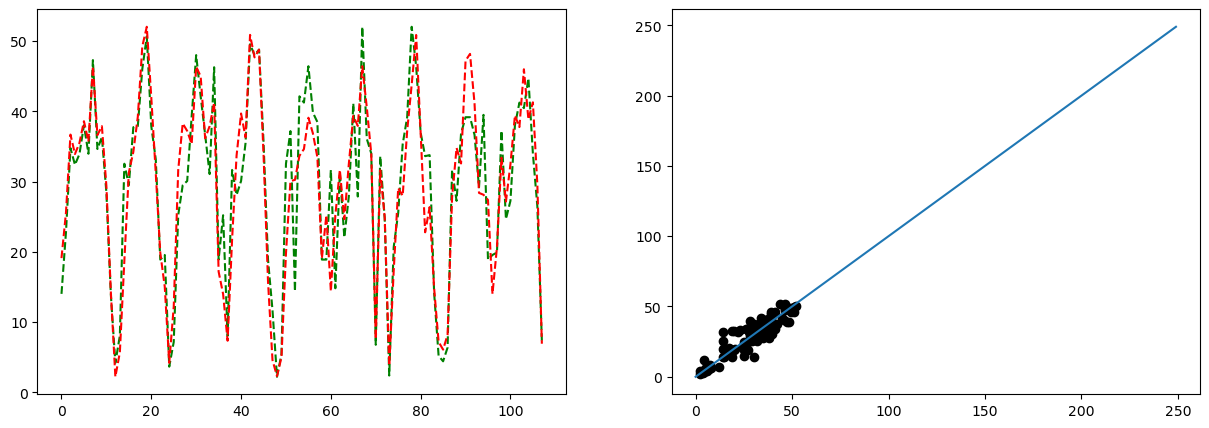

In [32]:
fig, axes = plt.subplots(ncols=2,figsize=(15,5))

axes[0].plot(cor_data, color='g', linestyle='--')
axes[0].plot(y_test, color='r', linestyle='--')


axes[1].plot(y_test, cor_data, 'ko')
axes[1].plot(range(250))

np.corrcoef(y_test.T.values[0], cor_data)[0,1]

# USING ALL EIGHT VARIABLES 

In [27]:
%%time

import pandas as pd

inp = pd.read_csv(r'point-data.csv',usecols=['time','d2m', 't2m','slhf','ssr','str','sshf','tp','lcc','r'])
inp['dd'] = inp.t2m - inp.d2m
T_in = inp[['ssr','dd','d2m', 't2m','str','sshf','lcc','r']]

T_out = inp['lcc']
lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(T_out)
T_out = pd.DataFrame(lab.fit_transform(T_out))

# T_out = y_transformed


ts = 0.25  #test_size in fraction
accuracies = dict()

# 'LogR', 'GBC'
# 'RNC', 'QDA','PAC','BNB','ETC','BC','ABC','LDA'
method = ['DT']


[a,b,c,d,e, model]=ML.model(T_in, T_out, test_size=0.2, method='DT')
#score.append(accuracy_score(d, e))
#score = np.copy(score)

    
    
#accuracies[m]=  score

#print('Model Accuracy after {:} iterations ranges between \nMin: {:.4f} and \nMax: {:.4f}'.format(nx+1, score.min(), score.max()))

CPU times: user 16 s, sys: 0 ns, total: 16 s
Wall time: 16 s


In [28]:
ann_inp = inp.set_index('time').copy()
ann_inp.index = pd.to_datetime(ann_inp.index)
ann_inp.groupby(pd.Grouper(freq='M')).sum()

,d2m,t2m,slhf,ssr,str,sshf,tp,lcc,r,dd
time,,,,,,,,,,
1975-01-31,17663.77086,18844.81316,-9334.202322,45736.668722,-8479.850656,-18232.464567,0.000098,2.788000,2122.922402,1181.04230
1975-02-28,16441.10510,16943.40864,-12904.300444,33569.454167,-4232.258972,-10208.303661,0.002900,20.419117,3156.242538,502.30354
1975-03-31,18301.93034,18749.38888,-16509.634750,35233.254978,-3659.238625,-9170.607556,0.004361,32.880015,3809.997864,447.45854
1975-04-30,17735.54266,18134.84472,-17067.757911,32041.892528,-2956.025139,-6891.185831,0.002666,40.679902,3788.020194,399.30206
1975-05-31,18326.24562,18713.07944,-16765.118644,31502.705389,-2996.835128,-6667.365706,0.005252,36.529687,4129.354148,386.83382
...,...,...,...,...,...,...,...,...,...,...
1999-08-31,18199.90190,18560.53440,-11888.629267,26959.933633,-2828.694191,-7884.221512,0.008870,45.997955,4224.584230,360.63250
1999-09-30,17658.70616,17978.50654,-13550.960183,25980.118317,-2412.045452,-5850.153925,0.028011,38.869242,4284.480400,319.80038
1999-10-31,18303.13490,18611.08828,-17194.139167,30759.020678,-2797.401789,-6008.850787,0.009884,41.292265,4538.614574,307.95338


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn import tree
model = DecisionTreeClassifier()

# Monthly Data

In [30]:
ann_inp = inp.set_index('time').copy()
ann_inp.index = pd.to_datetime(ann_inp.index)
ann_inp = ann_inp.groupby(pd.Grouper(freq='M')).sum()

T_in =ann_inp[['ssr','dd','d2m', 't2m','str','sshf','r']]
T_out = ann_inp[['lcc']]


    

    
    
x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)


lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(T_out)
y_train = pd.DataFrame(lab.fit_transform(y_train))


model.fit(x_train, y_train)

DecisionTreeClassifier()

0.8238268922783077

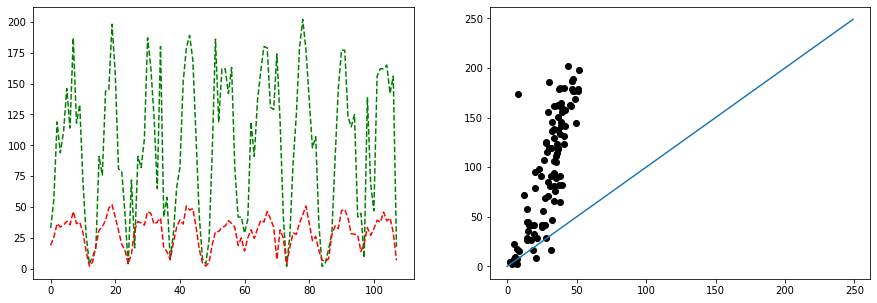

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

axes[0].plot(model.predict(x_test), color='g', linestyle='--')
axes[0].plot(y_test, color='r', linestyle='--')


axes[1].plot(y_test, model.predict(x_test), 'ko')
axes[1].plot(range(250))

np.corrcoef(y_test.T.values[0], model.predict(x_test))[0,1]

# Daily Data

In [32]:
ann_inp = inp.set_index('time').copy()
ann_inp.index = pd.to_datetime(ann_inp.index)
ann_inp = ann_inp.groupby(pd.Grouper(freq='D')).sum()

T_in =ann_inp[['ssr','dd','d2m', 't2m','str','sshf','r']]
T_out = ann_inp[['lcc']]


    

    
    
x_train = T_in.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
y_train = T_out.loc['1975':'1991'].reset_index().drop('time', axis=1).astype(float)
x_test = T_in.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)
y_test = T_out.loc['1991':'2000'].reset_index().drop('time', axis=1).astype(float)


lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(T_out)
y_train = pd.DataFrame(lab.fit_transform(y_train))


model.fit(x_train, y_train)

DecisionTreeClassifier()

0.6536612736034755

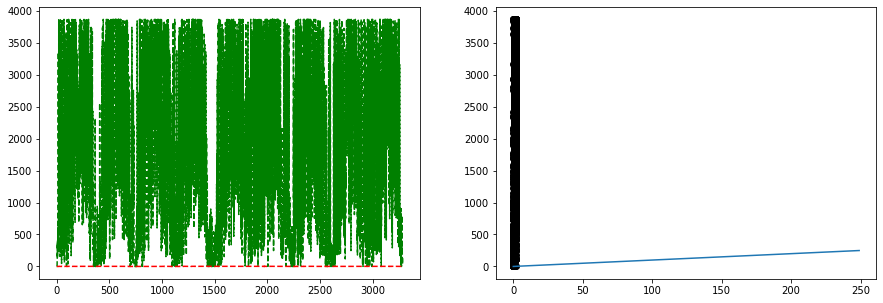

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

axes[0].plot(model.predict(x_test), color='g', linestyle='--')
axes[0].plot(y_test, color='r', linestyle='--')


axes[1].plot(y_test, model.predict(x_test), 'ko')
axes[1].plot(range(250))

np.corrcoef(y_test.T.values[0], model.predict(x_test))[0,1]

In [34]:
T_in

,ssr,dd,d2m,t2m,str,sshf,r
time,,,,,,,
1975-01-01,1482.965556,28.97680,577.91560,606.89240,-265.390244,-488.462533,78.133094
1975-01-02,1474.871222,22.96246,582.81640,605.77886,-248.566733,-521.793611,96.377366
1975-01-03,1460.016111,19.91304,585.78020,605.69324,-235.051422,-543.314306,105.059940
1975-01-04,1392.532500,26.77200,581.42520,608.19720,-244.163678,-514.589944,81.416230
1975-01-05,1462.621111,22.57318,583.35846,605.93164,-245.823644,-555.260222,99.574188
...,...,...,...,...,...,...,...
1999-12-27,1255.332222,18.03742,583.97266,602.01008,-186.711806,-326.007278,113.291756
1999-12-28,1397.835667,22.22792,581.70080,603.92872,-199.544289,-385.081944,98.122826
1999-12-29,1425.002778,18.42944,584.63128,603.06072,-202.157889,-416.516144,102.723052


In [35]:
T_out

,lcc
time,
1975-01-01,0.000000
1975-01-02,0.176339
1975-01-03,0.453359
1975-01-04,0.201547
1975-01-05,0.168831
...,...
1999-12-27,0.531854
1999-12-28,0.298476
1999-12-29,0.132574
